In [78]:
import os

import contextily as ctx
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from matplotlib import cm

In [86]:
enriched_points = dd.read_csv(
    "./anglova_metrics_enriched/points_enriched_metrics.csv",
).compute()
enriched_points["t"] = pd.to_datetime(enriched_points["t"])
enriched_trajectories_df = pd.read_csv(
    "./anglova_metrics_enriched/trajectories_enriched_metrics.csv",
)
output_path = "./assets/Spatial Projection/"
pallete = "Set1"
pallete2 = "Set2"

In [80]:
def save_plot(filename):
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    plt.savefig(
        f"{output_path}/{filename}.png",
        bbox_inches="tight",
    )
    plt.savefig(
        f"{output_path}/{filename}.pdf",
        bbox_inches="tight",
    )

In [81]:
cud_okabe_ito_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # reddish orange
    "#CC79A7",  # purple
    "#000000",  # black
]

C:\Users\edgar\AppData\Local\Temp\ipykernel_15356\1588300680.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=8)


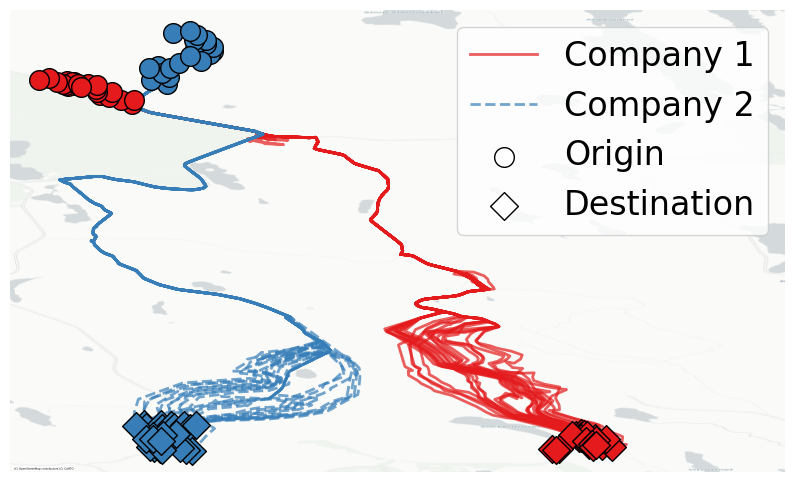

C:\Users\edgar\AppData\Local\Temp\ipykernel_15356\1588300680.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=8)


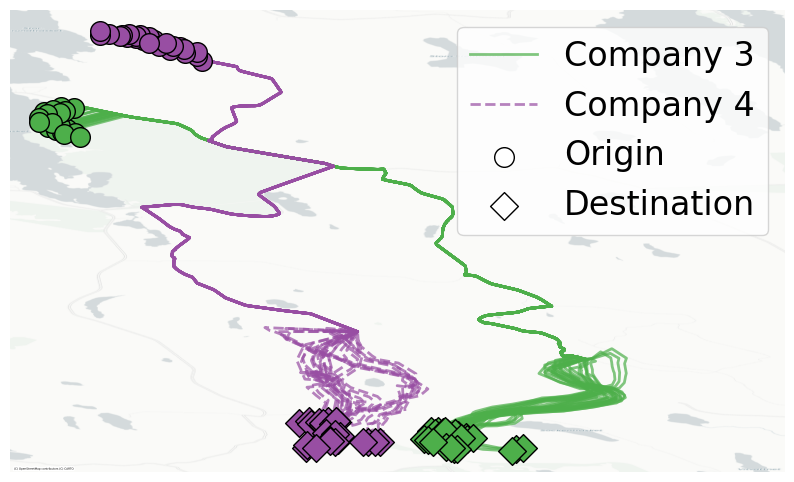

C:\Users\edgar\AppData\Local\Temp\ipykernel_15356\1588300680.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=8)


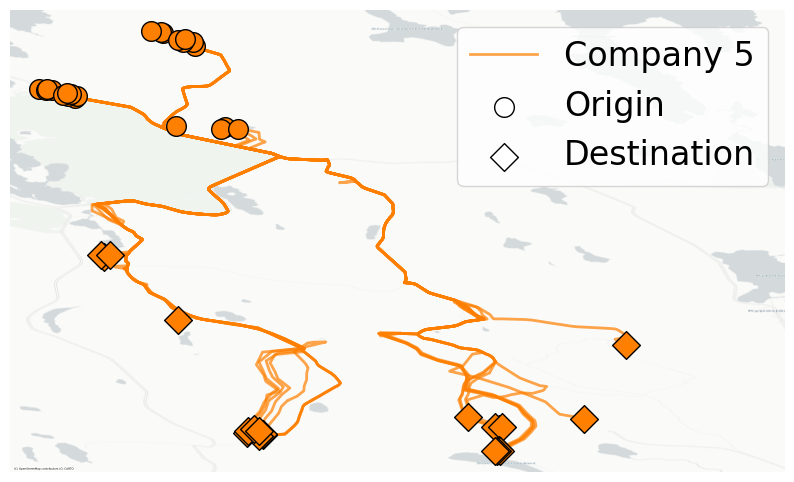

C:\Users\edgar\AppData\Local\Temp\ipykernel_15356\1588300680.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", fontsize=8)


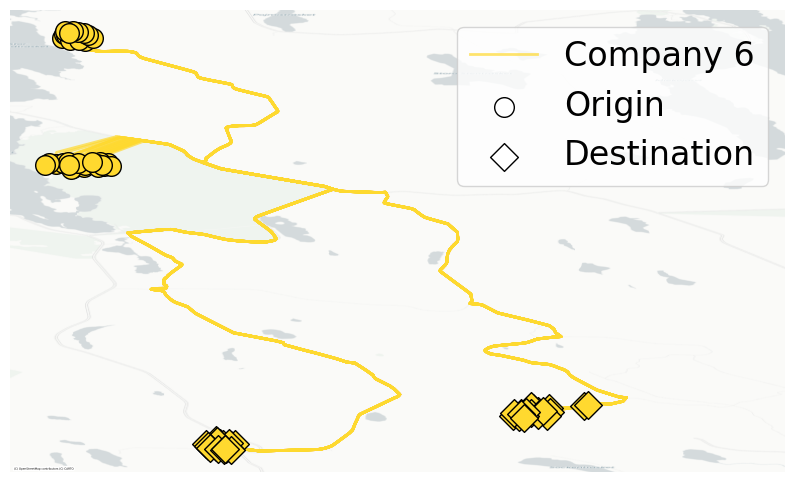

In [19]:
def plot_trajectories(data, companies, category, palette, filename):
    """
    Plots trajectories for the given companies and saves the plot.

    Parameters:
        data (DataFrame): The enriched points data.
        companies (list): List of company IDs to filter.
        category (str): The category column name.
        palette (str): The color palette to use.
        filename (str): The filename to save the plot.
    """
    # Filter data for the given companies
    filtered_data = data[data[category].isin(companies)]
    df = data[data["trajectory_id"].isin(filtered_data["trajectory_id"])]
    df = df.sort_values(by=["trajectory_id", "t"])

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.x, df.y), crs="EPSG:4326"
    )
    gdf = gdf.to_crs(epsg=3857)

    # Get bounding box and apply margins
    bbox = gdf.total_bounds
    margin_x = (bbox[2] - bbox[0]) * 0.05
    margin_y = (bbox[3] - bbox[1]) * 0.05
    minx, maxx = bbox[0] - margin_x, bbox[2] + margin_x
    miny, maxy = bbox[1] - margin_y, bbox[3] + margin_y

    # Get unique categories and set up the plot
    categorias = sorted(gdf[category].unique())
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.legend(loc="upper right", fontsize=8)

    # Plot each trajectory
    for _, traj in gdf.groupby("trajectory_id"):
        color = sns.color_palette(palette, 7)[traj[category].iloc[0] - 1]
        line_styles = ["-", "--", ":", "-.", (0, (3, 5, 1, 5)), (0, (5, 10))]
        line_style = line_styles[
            categorias.index(traj[category].iloc[0]) % len(categorias)
        ]
        ax.plot(
            traj.geometry.x,
            traj.geometry.y,
            line_style,
            color=color,
            linewidth=2,
            alpha=0.7,
            label=f"{category} {traj[category].iloc[0]}",
        )
        start_point = traj.groupby("trajectory_id").first()
        end_point = traj.groupby("trajectory_id").last()
        ax.scatter(
            start_point.geometry.x,
            start_point.geometry.y,
            color=color,
            edgecolor="black",
            marker="o",
            s=200,
            zorder=3,
        )
        ax.scatter(
            end_point.geometry.x,
            end_point.geometry.y,
            color=color,
            edgecolor="black",
            marker="D",
            s=200,
            zorder=3,
        )

    # Add legend and basemap
    ax.scatter(
        [],
        [],
        color="white",
        edgecolor="black",
        marker="o",
        s=200,
        label="Origin",
    )
    ax.scatter(
        [],
        [],
        color="white",
        edgecolor="black",
        marker="D",
        s=200,
        label="Destination",
    )
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(
        unique_labels.values(),
        unique_labels.keys(),
        loc="upper right",
        fontsize=24,
    )
    ax.axis("off")
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)
    # Extend the bounding box of the plot
    ax.set_xlim(
        ax.get_xlim()[0],
        ax.get_xlim()[1] + 0.2 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
    )
    ax.set_ylim(
        ax.get_ylim()[0],
        ax.get_ylim()[1] + 0 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
    )
    ctx.add_basemap(
        ax,
        crs=gdf.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        attribution_size=2,
    )

    # Save and show the plot
    save_plot(filename)
    plt.show()


# Example usage for each company group
plot_trajectories(enriched_points, [1, 2], "Company", "Set1", "Company_1_2")
plot_trajectories(enriched_points, [3, 4], "Company", "Set1", "Company_3_4")
plot_trajectories(enriched_points, [5], "Company", "Set1", "Company_5")
plot_trajectories(enriched_points, [6], "Company", "Set2", "Company_6")